# Hazardous Chemicals in Cosmetics

In [1]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read in the data set
input_data = "Resources/cosmetics_data.csv"
cosmetics_df = pd.read_csv(input_data, low_memory=False)
cosmetics_df.head(1)

,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,CasNumber,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
0,2,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,...,13463-67-7,6,Titanium dioxide,06/17/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1


# Data Cleaning

In [3]:
# Remove unnecessary columns
columns_to_drop = ["CDPHId", "CSFId", "CompanyId", "PrimaryCategoryId", "SubCategoryId", "CasId", "ChemicalId"]
cosmetics_cleaned_df = cosmetics_df.drop(columns=columns_to_drop)
cosmetics_cleaned_df.head(1)

,ProductName,CSF,CompanyName,BrandName,PrimaryCategory,SubCategory,CasNumber,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,NaN,New Avon LLC,AVON,Makeup Products (non-permanent),"Lip Color - Lipsticks, Liners, and Pencils",13463-67-7,Titanium dioxide,06/17/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1


In [4]:
# Change dates to datetime objects
cosmetics_cleaned_df["InitialDateReported"] = pd.to_datetime(cosmetics_cleaned_df["InitialDateReported"])
cosmetics_cleaned_df["MostRecentDateReported"] = pd.to_datetime(cosmetics_cleaned_df["MostRecentDateReported"])
cosmetics_cleaned_df["DiscontinuedDate"] = pd.to_datetime(cosmetics_cleaned_df["DiscontinuedDate"])
cosmetics_cleaned_df["ChemicalCreatedAt"] = pd.to_datetime(cosmetics_cleaned_df["ChemicalCreatedAt"])
cosmetics_cleaned_df["ChemicalUpdatedAt"] = pd.to_datetime(cosmetics_cleaned_df["ChemicalUpdatedAt"])
cosmetics_cleaned_df["ChemicalDateRemoved"] = pd.to_datetime(cosmetics_cleaned_df["ChemicalDateRemoved"])
cosmetics_cleaned_df.head(1)

,ProductName,CSF,CompanyName,BrandName,PrimaryCategory,SubCategory,CasNumber,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,NaN,New Avon LLC,AVON,Makeup Products (non-permanent),"Lip Color - Lipsticks, Liners, and Pencils",13463-67-7,Titanium dioxide,2009-06-17,2013-08-28,2011-02-01,2009-07-09,2009-07-09,NaT,1


In [5]:
# Check shape
cosmetics_cleaned_df.shape

(114635, 15)

In [6]:
# Check for duplicates
print(cosmetics_cleaned_df.duplicated().sum())

7701


In [7]:
# Drop duplicates and check shape again
cosmetics_cleaned_df = cosmetics_cleaned_df.drop_duplicates()
cosmetics_cleaned_df.shape

(106934, 15)

In [8]:
# Filter the dataset where the 'CasId' is missing (NaN)
missing_cas_df = cosmetics_cleaned_df[cosmetics_cleaned_df['CasNumber'].isna()]

# Select relevant columns like 'ChemicalName' and 'CasId' to inspect
missing_cas_df = missing_cas_df[['ChemicalName', 'CasNumber']]

# Select only the unique chemical names with missing CAS numbers
unique_missing_cas_df = missing_cas_df[['ChemicalName']].drop_duplicates()

# Group by 'ChemicalName' and count occurrences
missing_cas_count_df = missing_cas_df.groupby('ChemicalName').size().reset_index(name='Count')

# Merge the two DataFrames on 'ChemicalName'
missing_cas_chemicals_df = pd.merge(unique_missing_cas_df, missing_cas_count_df, on='ChemicalName', how='inner')

# Sort by the count column (assuming the count column is named 'Count')
missing_cas_chemicals_df = missing_cas_chemicals_df.sort_values(by='Count', ascending=False)
missing_cas_chemicals_df.head()

,ChemicalName,Count
4,"Silica, crystalline (airborne particles of res...",2461
9,Retinyl palmitate,1063
2,"Retinol/retinyl esters, when in daily dosages ...",682
11,"Mineral oils, untreated and mildly treated",510
12,Cocamide DEA,234


In [9]:
# Standardize name for all retinyl esters
cosmetics_cleaned_df.loc[cosmetics_cleaned_df["ChemicalName"] == "Retinyl palmitate", "ChemicalName"] = "Retinyl esters"
cosmetics_cleaned_df.loc[cosmetics_cleaned_df["ChemicalName"] == "Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.", "ChemicalName"] = "Retinyl esters"
cosmetics_cleaned_df.loc[cosmetics_cleaned_df["ChemicalName"] == "Retinyl acetate", "ChemicalName"] = "Retinyl esters"

In [10]:
# Standardize name for titanium dioxide
cosmetics_cleaned_df.loc[cosmetics_cleaned_df["ChemicalName"] == "Titanium dioxide (airborne, unbound particles of respirable size)", "ChemicalName"] = "Titanium dioxide"

In [11]:
# Standardize name for talc
cosmetics_cleaned_df.loc[cosmetics_cleaned_df["ChemicalName"] == "Cosmetic talc", "ChemicalName"] = "Talc"
cosmetics_cleaned_df.loc[cosmetics_cleaned_df["ChemicalName"] == "Talc (powder)", "ChemicalName"] = "Talc"
cosmetics_cleaned_df.loc[cosmetics_cleaned_df["ChemicalName"] == "Talc containing asbestiform fibers", "ChemicalName"] = "Talc"

In [12]:
# Standardize name for cocamide DEA
cosmetics_cleaned_df.loc[cosmetics_cleaned_df["ChemicalName"] == "Cocamide diethanolamine", "ChemicalName"] = "Cocamide DEA"

# 1. Which companies have the most reports of potentially hazardous chemicals?

In [19]:
# Group data by company name and chemical counts
companies_df = cosmetics_cleaned_df.groupby(["CompanyName", "ChemicalName"])["ChemicalName"].count().reset_index(name="ChemicalCount")
sorted_companies_df = companies_df.sort_values(by='ChemicalCount', ascending=False)
sorted_companies_df.head(20)

,CompanyName,ChemicalName,ChemicalCount
709,L'Oreal USA,Titanium dioxide,5711
1226,S+,Titanium dioxide,3900
334,Coty,Titanium dioxide,3700
149,"Bare Escentuals Beauty, Inc.",Titanium dioxide,3674
1366,The Procter & Gamble Company,Titanium dioxide,3344
1186,Revlon Consumer Product Corporation,Titanium dioxide,2997
1331,Tarte Cosmetics,Titanium dioxide,2381
942,Nars Cosmetics,Titanium dioxide,1987
80,American International Industries,Titanium dioxide,1755
1453,Victoria's Secret Beauty,Titanium dioxide,1702


In [20]:
# Put the top 20 in their own data frame
top20_companies_df = sorted_companies_df[sorted_companies_df['ChemicalCount'] >= 1021]
top20_companies_df

,CompanyName,ChemicalName,ChemicalCount
709,L'Oreal USA,Titanium dioxide,5711
1226,S+,Titanium dioxide,3900
334,Coty,Titanium dioxide,3700
149,"Bare Escentuals Beauty, Inc.",Titanium dioxide,3674
1366,The Procter & Gamble Company,Titanium dioxide,3344
1186,Revlon Consumer Product Corporation,Titanium dioxide,2997
1331,Tarte Cosmetics,Titanium dioxide,2381
942,Nars Cosmetics,Titanium dioxide,1987
80,American International Industries,Titanium dioxide,1755
1453,Victoria's Secret Beauty,Titanium dioxide,1702


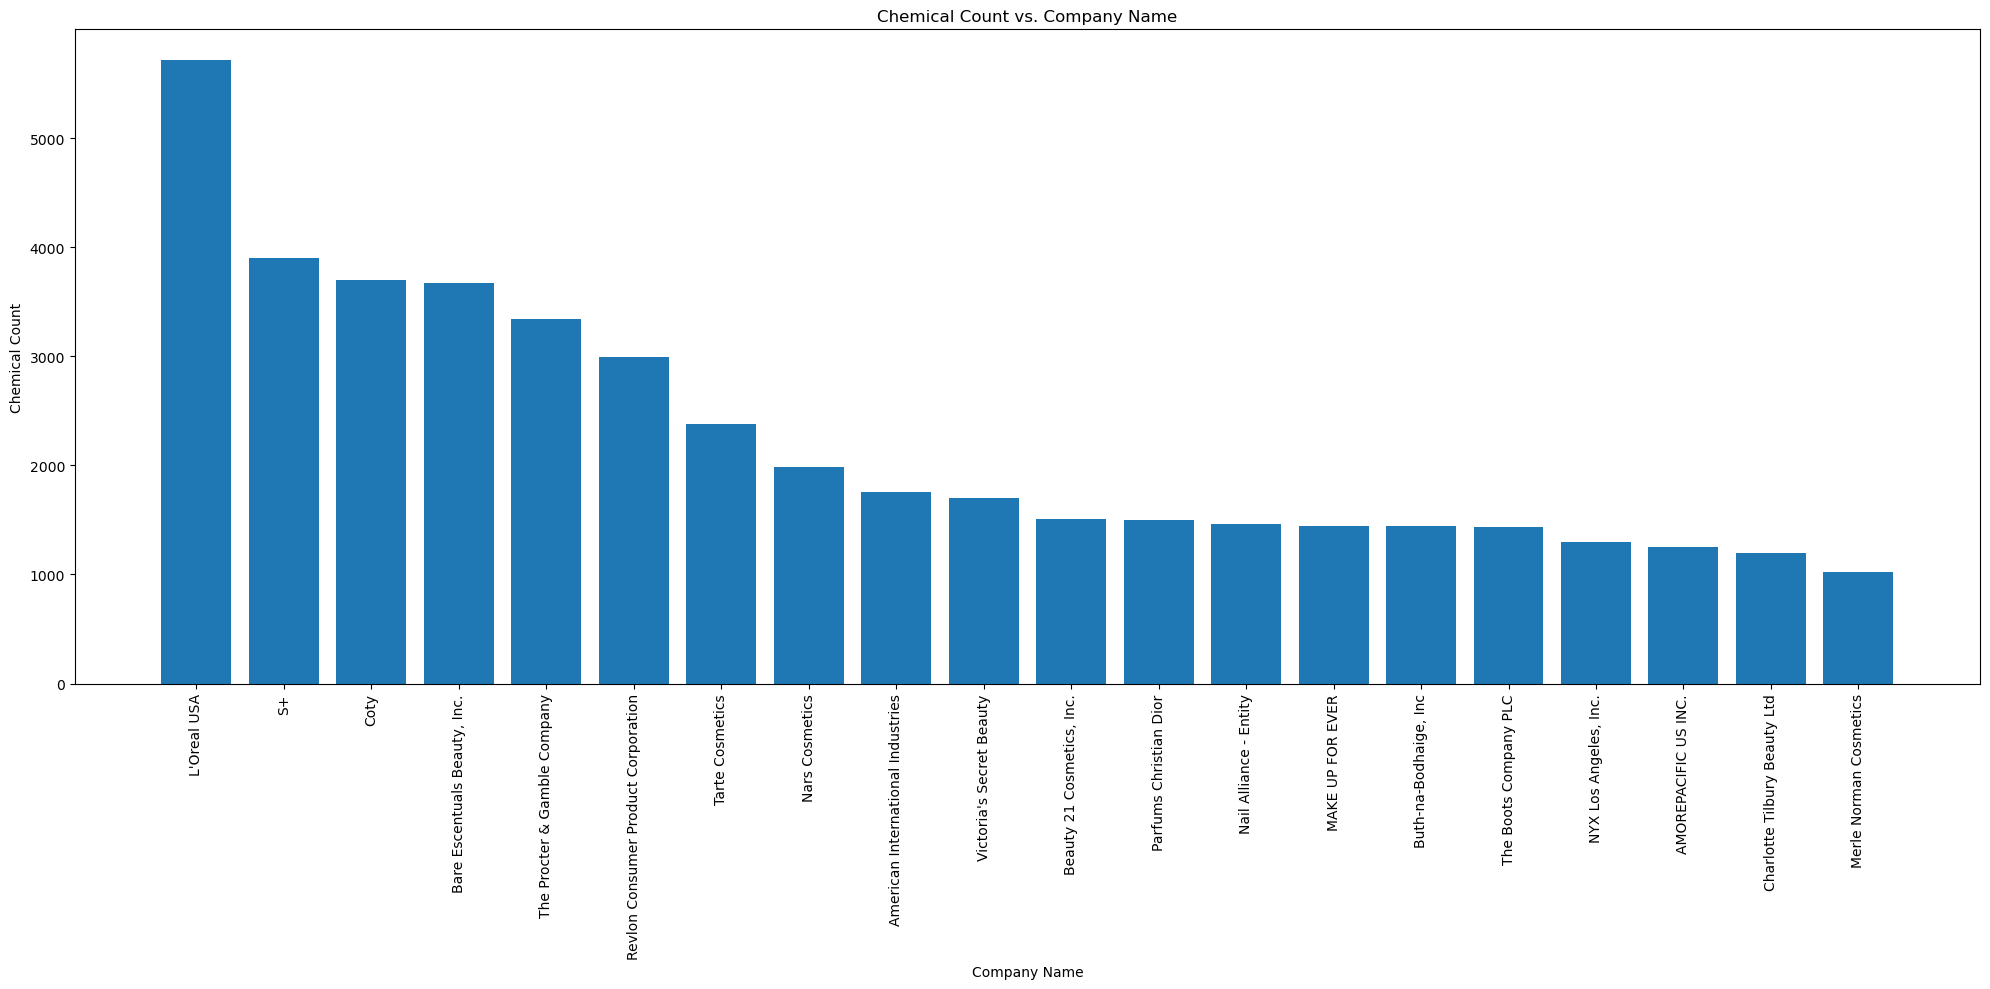

In [21]:
# Plotting the data
plt.figure(figsize=(20,10))

plt.bar(top20_companies_df["CompanyName"], top20_companies_df["ChemicalCount"])

plt.xlabel('Company Name')
plt.ylabel('Chemical Count')
plt.title('Chemical Count vs. Company Name')
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig("MA graphs\MA_graphs.png")
plt.show()

In [24]:
# Group data by brand name and chemical counts
brands_df = cosmetics_cleaned_df.groupby(["BrandName", "ChemicalName"])["ChemicalName"].count().reset_index(name="ChemicalCount")
sorted_brands_df = brands_df.sort_values(by="ChemicalCount", ascending=False)
sorted_brands_df.head(20)

,BrandName,ChemicalName,ChemicalCount
4124,bareMinerals,Titanium dioxide,3031
3175,SEPHORA,Titanium dioxide,2257
4219,tarte,Titanium dioxide,2021
2509,NARS,Titanium dioxide,1982
3090,Revlon,Titanium dioxide,1747
3320,Sephora,Titanium dioxide,1639
3945,Victoria's Secret Beauty,Titanium dioxide,1594
1052,CoverGirl,Titanium dioxide,1584
2818,Parfums Christian Dior,Titanium dioxide,1477
2258,MAKE UP FOR EVER,Titanium dioxide,1444


In [26]:
# Put the top 20 brands in their own data frame
top20_brands_df = sorted_brands_df[sorted_brands_df["ChemicalCount"] >= 989]
top20_brands_df

,BrandName,ChemicalName,ChemicalCount
4124,bareMinerals,Titanium dioxide,3031
3175,SEPHORA,Titanium dioxide,2257
4219,tarte,Titanium dioxide,2021
2509,NARS,Titanium dioxide,1982
3090,Revlon,Titanium dioxide,1747
3320,Sephora,Titanium dioxide,1639
3945,Victoria's Secret Beauty,Titanium dioxide,1594
1052,CoverGirl,Titanium dioxide,1584
2818,Parfums Christian Dior,Titanium dioxide,1477
2258,MAKE UP FOR EVER,Titanium dioxide,1444


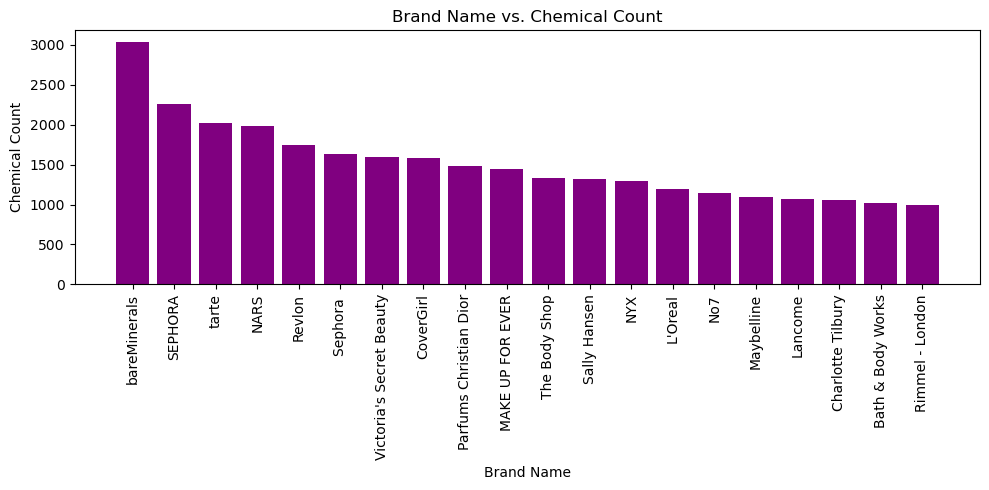

In [27]:
# Plotting the data
plt.figure(figsize=(10,5))

plt.bar(top20_brands_df["BrandName"], top20_brands_df["ChemicalCount"], color="purple")

plt.xlabel('Brand Name')
plt.ylabel('Chemical Count')
plt.title('Brand Name vs. Chemical Count')
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig("MA graphs\MA_graphs1.png")

plt.show()

In [30]:
# Check company chemical reports, not including titanium dioxide
not_titanium_reports_df = cosmetics_cleaned_df.groupby(["CompanyName", "ChemicalName"])["ChemicalName"].count().reset_index(name="ChemicalCount")
rmv_titanuim_df = not_titanium_reports_df.loc[not_titanium_reports_df["ChemicalName"] != "Titanium dioxide"]
sorted_rmv_titanuim_df = rmv_titanuim_df.sort_values(by="ChemicalCount", ascending=False)
sorted_rmv_titanuim_df.head(20)

,CompanyName,ChemicalName,ChemicalCount
333,Coty,Retinyl esters,958
276,Charlotte Tilbury Beauty Ltd,"Silica, crystalline (airborne particles of res...",846
928,Nail Alliance - Entity,"Silica, crystalline (airborne particles of res...",566
924,"NYX Los Angeles, Inc.",Butylated hydroxyanisole,551
1223,S+,Mica,544
1225,S+,Talc,370
1511,ZOEVA GmbH,Talc,368
726,LI Pigments,Carbon black,344
150,Bath & Body Works,Retinyl esters,319
508,GUERLAIN,Mica,303


In [33]:
# Put the top 20 companies in their own data frame
top20_rmv_titanuim_df = sorted_rmv_titanuim_df[sorted_rmv_titanuim_df['ChemicalCount'] >= 180 ]
top20_rmv_titanuim_df

,CompanyName,ChemicalName,ChemicalCount
333,Coty,Retinyl esters,958
276,Charlotte Tilbury Beauty Ltd,"Silica, crystalline (airborne particles of res...",846
928,Nail Alliance - Entity,"Silica, crystalline (airborne particles of res...",566
924,"NYX Los Angeles, Inc.",Butylated hydroxyanisole,551
1223,S+,Mica,544
1225,S+,Talc,370
1511,ZOEVA GmbH,Talc,368
726,LI Pigments,Carbon black,344
150,Bath & Body Works,Retinyl esters,319
508,GUERLAIN,Mica,303


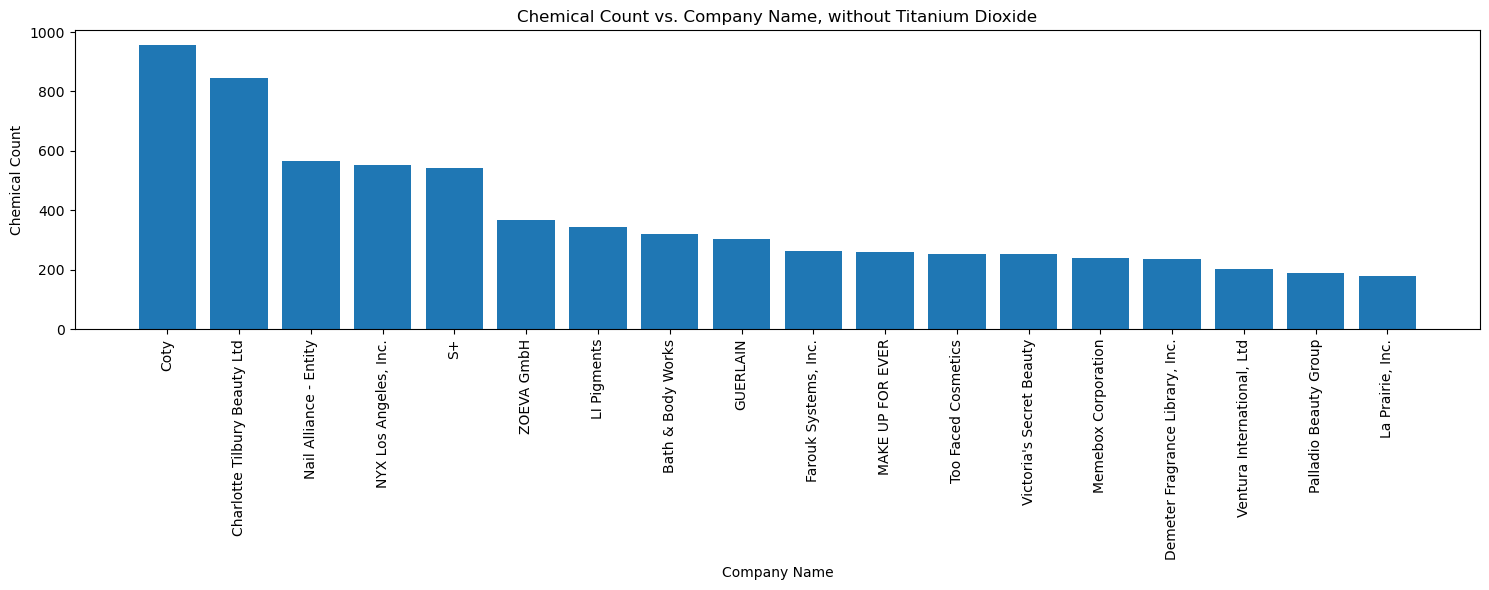

In [34]:
# Plotting the data
plt.figure(figsize=(15,6))

plt.bar(top20_rmv_titanuim_df["CompanyName"], top20_rmv_titanuim_df["ChemicalCount"])

plt.xlabel('Company Name')
plt.ylabel('Chemical Count')
plt.title('Chemical Count vs. Company Name, without Titanium Dioxide')
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig("MA graphs\MA_graphs2.png")

plt.show()

# 2. Which potentially hazardous chemicals have been reported the most?

In [49]:
# Extract chemical data and remove duplicates
chemical_data_df = cosmetics_cleaned_df[['ChemicalName', 'CasNumber']]
chemical_data_df.head()

,ChemicalName,CasNumber
0,Titanium dioxide,13463-67-7
1,Distillates (coal tar),65996-92-1
2,Estragole,140-67-0
3,Titanium dioxide,13463-67-7
4,Titanium dioxide,13463-67-7


In [50]:
# Count occurrences and get the top 10 chemicals
chemical_counts = chemical_data_df['ChemicalName'].value_counts()
top_10_chemicals = chemical_counts.head(10)
top_10_chemicals

ChemicalName
Titanium dioxide                                               87529
Retinyl esters                                                  3174
Silica, crystalline (airborne particles of respirable size)     2461
Mica                                                            1835
Talc                                                            1734
Carbon black                                                    1704
Cocamide DEA                                                    1595
Butylated hydroxyanisole                                        1301
Vitamin A palmitate                                              953
Mineral oils, untreated and mildly treated                       512
Name: count, dtype: int64

In [51]:
# Defining a function for shortening the names on the chart
def shorten_name(name):
    return name if len(name) <= 30 else name[:30] + '...'
shortened_labels = [shorten_name(name) for name in top_10_chemicals.index]

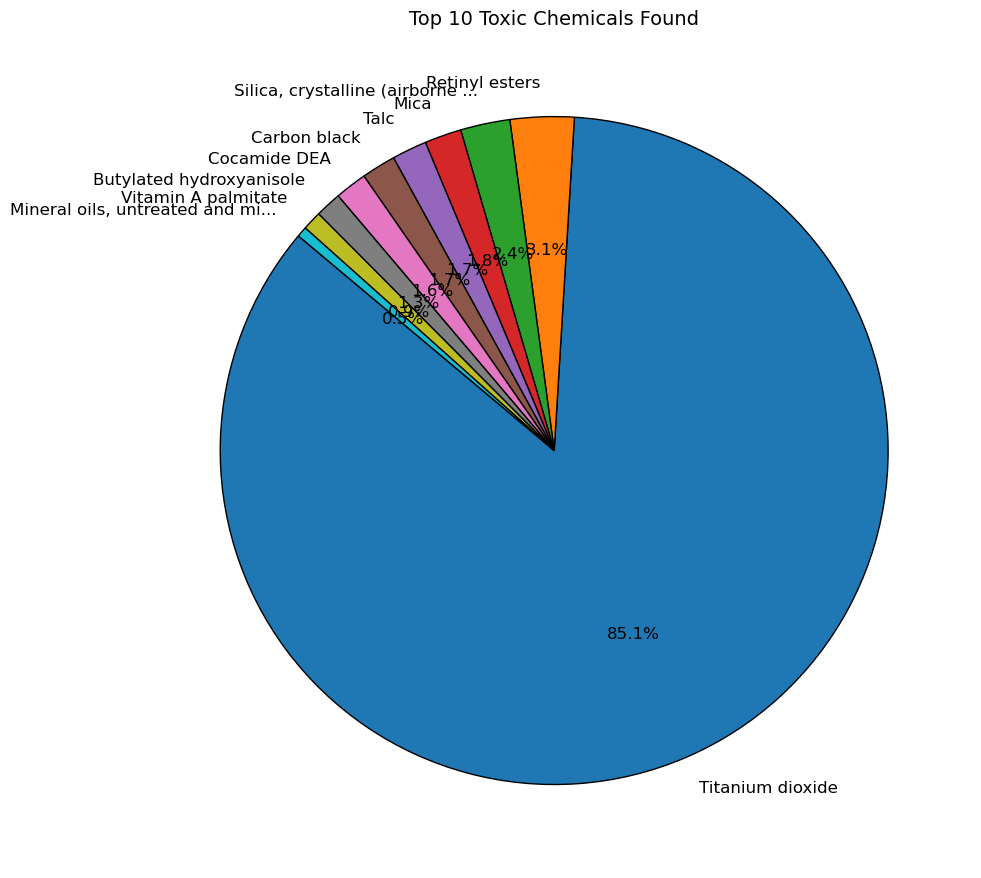

In [52]:
# Create pie chart
plt.figure(figsize=(10, 10))
plt.pie(top_10_chemicals.values, labels=shortened_labels, autopct='%1.1f%%',
        startangle=140, textprops={'fontsize': 12}, wedgeprops={'edgecolor': 'black'})

# Set title and layout
plt.title('Top 10 Toxic Chemicals Found', fontsize=14)
plt.tight_layout()

# Show chart
plt.show()

# 3. Which product categories contain the most reports of potentially hazardous chemicals?

In [58]:
# Group data by categories
categories_df = cosmetics_cleaned_df.groupby('PrimaryCategory')['ChemicalName'].nunique()
sorted_categories_df = categories_df.sort_values(ascending=False)
sorted_categories_df

PrimaryCategory
Skin Care Products                   78
Hair Care Products (non-coloring)    65
Makeup Products (non-permanent)      48
Bath Products                        39
Sun-Related Products                 38
Nail Products                        30
Personal Care Products               29
Hair Coloring Products               22
Fragrances                           21
Shaving Products                     17
Baby Products                        11
Oral Hygiene Products                 6
Tattoos and Permanent Makeup          4
Name: ChemicalName, dtype: int64

In [61]:
# Put the top 10 categories in their own set
top_10_categories = sorted_categories_df.head(10)
top_10_categories

PrimaryCategory
Skin Care Products                   78
Hair Care Products (non-coloring)    65
Makeup Products (non-permanent)      48
Bath Products                        39
Sun-Related Products                 38
Nail Products                        30
Personal Care Products               29
Hair Coloring Products               22
Fragrances                           21
Shaving Products                     17
Name: ChemicalName, dtype: int64

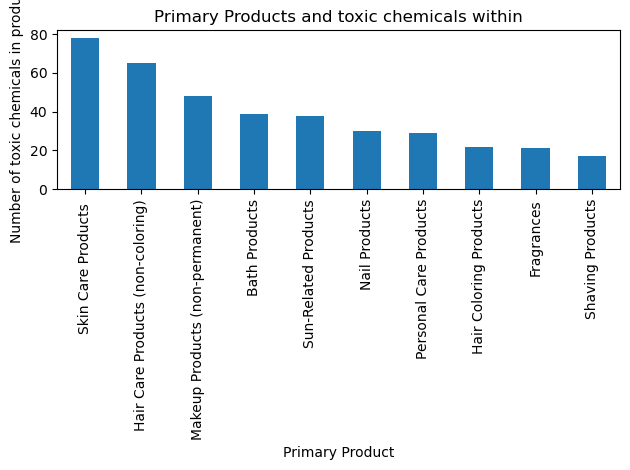

In [62]:
# Plotting the data
top_10_categories.plot(kind='bar') 
plt.title('Primary Products and toxic chemicals within')
plt.xlabel('Primary Product')
plt.ylabel("Number of toxic chemicals in products")
plt.tight_layout()
plt.show()

# 4. What kind of changes were there in the reporting of potentially hazardous chemicals from year to year?

# 5. How frequently were products with potentially hazardous chemicals reported to be discontinued?